# MVP – Predição de Churn em Clientes de Telecom

## Etapa 0 – Problema de Negócio

Um dos maiores desafios enfrentados por empresas de telecomunicações é a **retenção de clientes**.  
O chamado **churn** – termo usado para indicar o cancelamento de serviços por parte do cliente – representa uma ameaça direta à sustentabilidade do negócio.

Na prática, adquirir novos clientes costuma ser **muito mais caro** do que reter os atuais.  
Portanto, identificar quais clientes estão mais propensos a cancelar permite que a empresa atue de forma **proativa**, oferecendo condições especiais ou estratégias personalizadas de retenção.

O objetivo deste trabalho é desenvolver um **modelo preditivo de churn** utilizando dados históricos de clientes.  
A proposta é construir um MVP que:  
- seja capaz de **identificar clientes em risco de churn**,  
- permita compreender **quais variáveis influenciam mais na decisão de cancelamento**,  
- e apoie o negócio na **tomada de decisão estratégica** para reduzir perdas de receita.

# Estrutura do Notebook

- Etapa 0: Problema de Negócio
- Etapa 1: Exploração inicial do dataset
- Etapa 2: Preparação dos dados
- Etapa 3: Definição do baseline
- Etapa 4: Modelos candidatos
- Etapa 5: Tuning de hiperparâmetros
- Etapa 6: Avaliação dos resultados
- Etapa 7: Interpretação e insights de negócio
- Etapa 8: Conclusão
- Etapa 9: Checklist final
- Etapa 10: Reprodutibilidade
- Etapa 11: Referências

# Etapa 1 – Exploração inicial do dataset

O primeiro passo é preparar o ambiente de análise, garantindo que todas as bibliotecas necessárias estejam carregadas e que os experimentos sejam **reprodutíveis**.  

Em seguida, farei o carregamento do dataset de churn de clientes de telecomunicações, que servirá como base para todo o desenvolvimento do MVP.  
O objetivo é começar a compreender a estrutura dos dados, suas variáveis e potenciais desafios de qualidade que precisaremos tratar antes da modelagem.


## 1.1 — Setup do ambiente

Antes de explorar os dados, é necessário garantir que o ambiente de trabalho esteja preparado.  
Aqui importo as bibliotecas que utilizarei ao longo do projeto e defino uma **seed global** para manter a reprodutibilidade dos resultados.


In [ ]:
# importando bibliotecas principais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# definindo seed global para reprodutibilidade
np.random.seed(42)

# ativando estilo visual global
import matplotlib as mpl
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_theme(context="notebook", style="whitegrid")

mpl.rcParams["figure.figsize"] = (7, 4)
mpl.rcParams["axes.titlesize"] = 12
mpl.rcParams["axes.labelsize"] = 11

print("Setup inicial concluído. Bibliotecas carregadas, seed e estilo visual definidos.")


Setup inicial concluído. Bibliotecas carregadas, seed e estilo visual definidos.


## 1.2 — Carregamento do dataset

O dataset será carregado diretamente da URL **raw** do meu repositório no GitHub.  
Essa abordagem facilita a execução em qualquer ambiente sem depender de uploads manuais.  
Em seguida, serão feitas checagens rápidas para confirmar a presença das colunas essenciais e será aplicado um ajuste conhecido neste dataset: `TotalCharges` pode vir como string e precisa ser convertido para numérico com segurança.


In [ ]:
# lendo dataset via URL raw do GitHub
url = "https://raw.githubusercontent.com/marcusrobalino/mvp_machine_learning/refs/heads/main/telco_churn_dataset.csv"
df = pd.read_csv(url)

# padronizando coluna alvo (Yes/No -> 1/0)
if 'Churn' in df.columns:
    df['Churn'] = (df['Churn'].astype(str).str.strip().str.lower() == 'yes').astype(int)

# convertendo TotalCharges para numérico quando existir
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# validando colunas essenciais
required = {'customerID', 'Churn'}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Colunas obrigatórias ausentes: {missing}")

print("Dataset carregado e ajustes iniciais aplicados.")


Dataset carregado e ajustes iniciais aplicados.


## 1.3 — Análise estrutural

Agora será criada uma **fotografia objetiva** da base:
- Dimensão (linhas x colunas) e uma amostra das primeiras linhas.
- Tipos de dados por coluna (numéricas vs categóricas).
- Mapa de valores ausentes.
- Distribuição da variável-alvo (`Churn`) para identificar **desbalanceamento**.
- Cardinalidade das variáveis categóricas (útil para decisões de modelagem).

Essa visão inicial ajuda a antecipar decisões de **pré-processamento** (imputação, codificação, escala) que serão aplicadas na próxima etapa.


In [ ]:
# checando dimensões e amostra
print("Dimensões (linhas, colunas):", df.shape)
display(df.head(5))

# tipos de dados
print("\nTipos de dados por coluna:")
print(df.dtypes)

# valores ausentes (top 15)
na_counts = df.isna().sum().sort_values(ascending=False)
print("\nValores ausentes por coluna (top 15):")
print(na_counts.head(15))

# separando colunas numéricas e categóricas (excluindo ID)
id_cols = ['customerID']
num_cols = df.drop(columns=id_cols, errors='ignore').select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.drop(columns=id_cols, errors='ignore').select_dtypes(include=['object','bool']).columns.tolist()

print("\nQuantitativo de colunas:")
print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")

# cardinalidade de categóricas (top 10 por maior cardinalidade)
card = df[cat_cols].nunique().sort_values(ascending=False) if cat_cols else pd.Series(dtype='int')
if not card.empty:
    print("\nCardinalidade de variáveis categóricas (top 10):")
    print(card.head(10))

# distribuição do target
if 'Churn' in df.columns:
    print("\nDistribuição do target (Churn):")
    print(df['Churn'].value_counts(dropna=False))
    print("\nProporção do target (Churn):")
    print((df['Churn'].value_counts(normalize=True) * 100).round(2).astype(str) + "%")


Dimensões (linhas, colunas): (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1



Tipos de dados por coluna:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

Valores ausentes por coluna (top 15):
TotalCharges        11
gender               0
SeniorCitizen        0
Partner              0
customerID           0
Dependents           0
tenure               0
MultipleLines        0
PhoneService         0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
InternetService      0
TechSupport          0
Streaming

## 1.4 — Exploração descritiva

Com a estrutura entendida, continuamos para uma visão **descritiva** das variáveis mais relevantes.  
O objetivo aqui é identificar padrões iniciais e hipóteses que orientem o pré-processamento e a modelagem:

- Estatísticas descritivas para variáveis **numéricas** (`tenure`, `MonthlyCharges`, `TotalCharges`).
- Distribuições simples das principais variáveis numéricas (para avaliar assimetria, outliers e possíveis transformações).
- Análise de **taxa de churn** por variáveis categóricas-chave (ex.: `Contract`, `InternetService`, `PaymentMethod`), buscando relações intuitivas com cancelamento.
- Criação de **faixas de `tenure`** (tempo de casa) para observar como a maturidade do cliente afeta o churn.

Essa leitura inicial direciona as decisões de **pré-processamento** (imputação, codificação e escala) que virão na próxima etapa.


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80
Churn,7043.0,0.265370,0.441561,0.00,0.00,0.000,1.0000,1.00


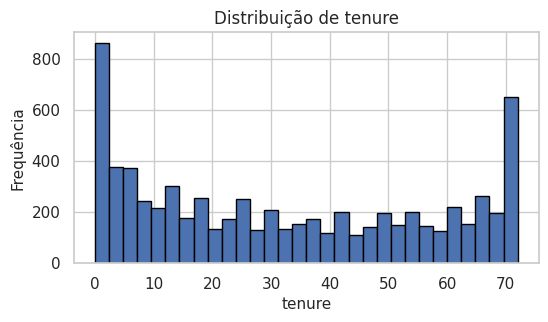

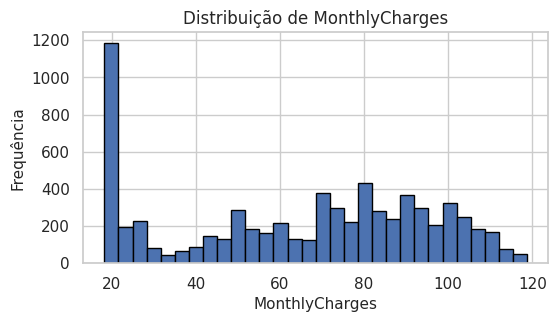

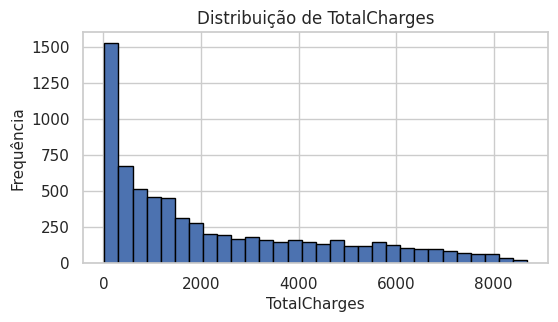


Taxa de churn por Contract:


,Churn
Contract,
Month-to-month,42.71%
One year,11.27%
Two year,2.83%


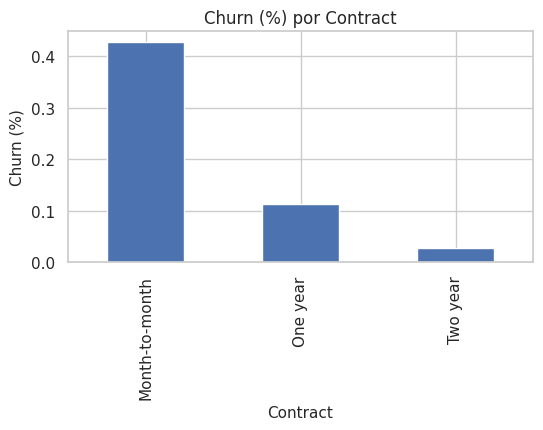


Taxa de churn por InternetService:


,Churn
InternetService,
Fiber optic,41.89%
DSL,18.96%
No,7.4%


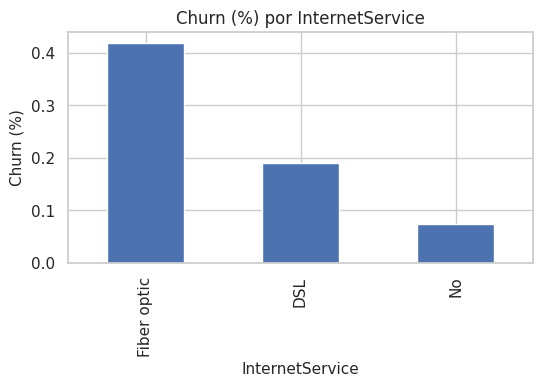


Taxa de churn por PaymentMethod:


,Churn
PaymentMethod,
Electronic check,45.29%
Mailed check,19.11%
Bank transfer (automatic),16.71%
Credit card (automatic),15.24%


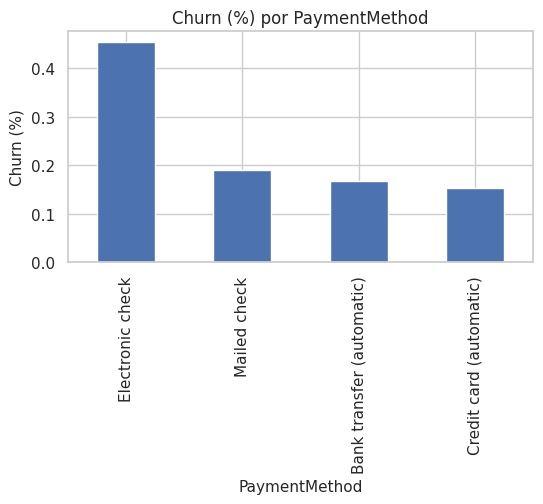


Taxa de churn por PaperlessBilling:


,Churn
PaperlessBilling,
Yes,33.57%
No,16.33%


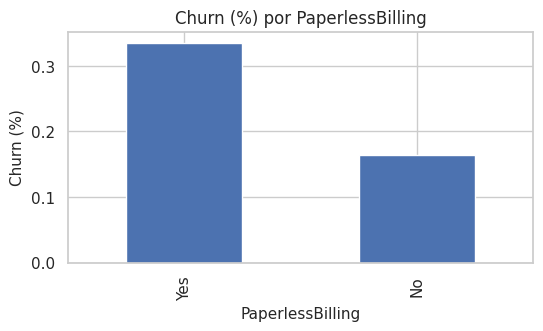


Taxa de churn por Partner:


,Churn
Partner,
No,32.96%
Yes,19.66%


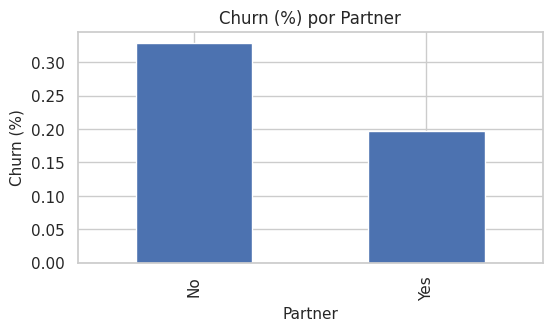


Taxa de churn por Dependents:


,Churn
Dependents,
No,31.28%
Yes,15.45%


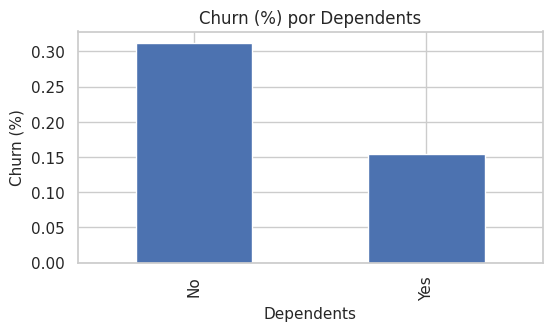


Churn (%) por faixa de tenure:


,Churn
tenure_bin,
≤6m,52.94%
7–12m,35.89%
13–24m,28.71%
25–48m,20.39%
>48m,9.51%


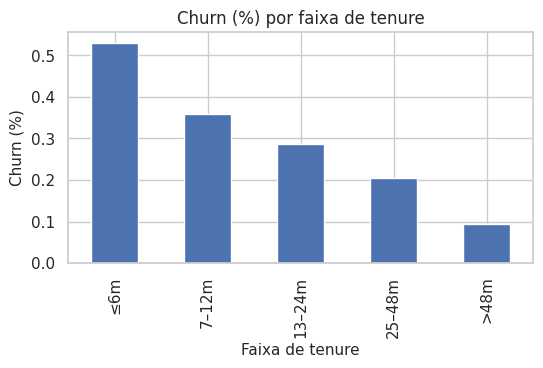

In [ ]:
# calculando estatísticas de variáveis numéricas
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
for col_id in ['customerID']:
    if col_id in num_cols:
        num_cols.remove(col_id)
display(df[num_cols].describe().T)

# plotando histogramas das variáveis numéricas principais
plot_cols = [c for c in ['tenure','MonthlyCharges','TotalCharges'] if c in df.columns]
for c in plot_cols:
    df[c].plot(kind='hist', bins=30, edgecolor='black', figsize=(6,3), title=f'Distribuição de {c}')
    plt.xlabel(c)
    plt.ylabel('Frequência')
    plt.show()

# calculando taxa de churn por variáveis categóricas relevantes
cat_focus = [c for c in ['Contract','InternetService','PaymentMethod','PaperlessBilling','Partner','Dependents'] if c in df.columns]
for c in cat_focus:
    rate = df.groupby(c, observed=False)['Churn'].mean().sort_values(ascending=False)
    print(f"\nTaxa de churn por {c}:")
    display((rate*100).round(2).astype(str) + "%")
    rate.plot(kind='bar', figsize=(6,3), title=f"Churn (%) por {c}")
    plt.ylabel('Churn (%)')
    plt.xlabel(c)
    plt.show()

# criando faixas de tenure e calculando churn por faixa (com observed=False para evitar FutureWarning)
if 'tenure' in df.columns:
    bins = [0, 6, 12, 24, 48, np.inf]
    labels = ['≤6m','7–12m','13–24m','25–48m','>48m']
    df['tenure_bin'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=True, include_lowest=True)

    rate_tenure = df.groupby('tenure_bin', observed=False)['Churn'].mean().reindex(labels)
    print("\nChurn (%) por faixa de tenure:")
    display((rate_tenure*100).round(2).astype(str) + "%")

    rate_tenure.plot(kind='bar', figsize=(6,3), title="Churn (%) por faixa de tenure")
    plt.ylabel('Churn (%)')
    plt.xlabel('Faixa de tenure')
    plt.show()


# Etapa 2 – Preparação dos dados

Agora que já conhecemos a estrutura e as distribuições do dataset, é preciso preparar os dados para a modelagem.  
Essa etapa é crucial, pois garante que os algoritmos recebam os dados no formato adequado e que não ocorra nenhum tipo de vazamento de informação.

As principais atividades aqui serão:
- **2.1 – Definição de variáveis**: separar a variável-alvo, descartar colunas irrelevantes e organizar numéricas/categóricas.
- **2.2 – Split treino/teste**: dividir o dataset garantindo estratificação da variável `Churn`.
- **2.3 – Pré-processamento com `ColumnTransformer`**: definir tratamento de valores ausentes, normalização de numéricas e codificação de categóricas.
- **2.4 – Validações rápidas de vazamento**: checar se o pipeline só aprendeu com dados de treino e não acessou indevidamente o conjunto de teste.

Esse preparo é a base para os experimentos de modelagem que virão a seguir.


## 2.1 – Definição de variáveis

O primeiro passo é separar claramente:
- A variável-alvo (`Churn`).
- O identificador (`customerID`), que não traz valor preditivo e deve ser removido.
- As colunas numéricas e categóricas, que receberão transformações distintas.


In [ ]:
# definindo target e removendo colunas irrelevantes
y = df['Churn']
X = df.drop(columns=['Churn','customerID'], errors='ignore')

# identificando colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','bool']).columns.tolist()

print("Target definido e colunas separadas.")
print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")


Target definido e colunas separadas.
Numéricas: 4 | Categóricas: 15


## 2.2 – Split treino/teste

Para avaliar o desempenho dos modelos, divido os dados em treino (80%) e teste (20%).  
Uso **estratificação** para manter a proporção da variável `Churn` em ambos os conjuntos.


In [ ]:
# criando divisão treino/teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Divisão concluída.")
print("Treino:", X_train.shape, " | Teste:", X_test.shape)
print("Proporção de churn no treino:", round(y_train.mean()*100,2), "%")
print("Proporção de churn no teste:", round(y_test.mean()*100,2), "%")

Divisão concluída.
Treino: (5634, 20)  | Teste: (1409, 20)
Proporção de churn no treino: 26.54 %
Proporção de churn no teste: 26.54 %


## 2.3 – Pré-processamento com ColumnTransformer

Criação do pipeline de pré-processamento:
- **Numéricas**: imputação da mediana + padronização com `StandardScaler`.
- **Categóricas**: imputação do valor mais frequente + codificação `OneHotEncoder`.

É usado `ColumnTransformer` para aplicar automaticamente o tratamento certo em cada tipo de variável.  
Esse pipeline será reutilizado em todos os modelos, garantindo **reprodutibilidade** e **consistência**.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# pipeline numéricas
num_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# pipeline categóricas
cat_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# combinando com ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_tf, num_cols),
        ('cat', cat_tf, cat_cols)
    ]
)

print("Pré-processador criado com sucesso.")


Pré-processador criado com sucesso.


## 2.4 – Validações rápidas de vazamento

Antes de seguir para os modelos, será feito um teste simples:  
- Ajuste do `preprocessor` somente nos dados de treino (`fit`).
- Transformo o treino e o teste separadamente (`transform`).  
Assim garantimos que nenhuma informação do conjunto de teste foi usada indevidamente durante o ajuste.


In [ ]:
# ajustando pré-processador no treino
preprocessor.fit(X_train)

# transformando treino e teste
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Transformações aplicadas sem vazamento.")
print("Shape treino:", X_train_proc.shape, "| Shape teste:", X_test_proc.shape)


Transformações aplicadas sem vazamento.
Shape treino: (5634, 45) | Shape teste: (1409, 45)


# Etapa 3 – Definição do baseline

Antes de testar modelos sofisticados, é fundamental criar uma **linha de base (baseline)**.  
Essa etapa garante que tenha um ponto de comparação: se os modelos avançados não superarem o baseline, significa que não entregam valor real.

No problema de churn, as duas referências escolhidas serão:
- **DummyClassifier (estratégia "most_frequent")**: sempre prediz a classe mais comum.
- **Logistic Regression** simples: modelo clássico, rápido e interpretável.

Essas escolhas me permitem comparar ganhos de performance com soluções extremamente básicas.


## 3.1 – DummyClassifier

O DummyClassifier é um modelo propositalmente ingênuo.  
Aqui uso a estratégia `most_frequent`, que prevê sempre a classe majoritária.  
No caso do churn, deve prever "não churn" para todos os clientes.  
Isso me dá um limite inferior de performance, essencial para validar os ganhos posteriores.


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, roc_auc_score

# criando pipeline baseline com dummy
pipe_dummy = Pipeline(steps=[('pre', preprocessor),
                             ('clf', DummyClassifier(strategy='most_frequent'))])

# treino e predição
pipe_dummy.fit(X_train, y_train)
y_pred_dummy = pipe_dummy.predict(X_test)
y_proba_dummy = pipe_dummy.predict_proba(X_test)[:,1]

# métricas
print("== DummyClassifier ==")
print(classification_report(y_test, y_pred_dummy, digits=3, zero_division=0))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_dummy), 3))


== DummyClassifier ==
              precision    recall  f1-score   support

           0      0.735     1.000     0.847      1035
           1      0.000     0.000     0.000       374

    accuracy                          0.735      1409
   macro avg      0.367     0.500     0.423      1409
weighted avg      0.540     0.735     0.622      1409

ROC-AUC: 0.5


## 3.2 – Logistic Regression (baseline interpretável)

A Regressão Logística é um modelo simples, porém muito usado em churn pela sua **interpretabilidade**.  
Aqui é utilizado `class_weight="balanced"` para lidar com o desbalanceamento da base.  
O objetivo é ter uma referência inicial de modelo estatístico clássico.


In [ ]:
from sklearn.linear_model import LogisticRegression

# pipeline com regressão logística
pipe_lr = Pipeline(steps=[('pre', preprocessor),
                          ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))])

# treino e predição
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]

# métricas
print("== Logistic Regression ==")
print(classification_report(y_test, y_pred_lr, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_lr), 3))


== Logistic Regression ==
              precision    recall  f1-score   support

           0      0.902     0.722     0.802      1035
           1      0.504     0.783     0.614       374

    accuracy                          0.738      1409
   macro avg      0.703     0.753     0.708      1409
weighted avg      0.797     0.738     0.752      1409

ROC-AUC: 0.841


# Etapa 4 – Modelos candidatos

Com o baseline estabelecido, seguimos para a avaliação de modelos mais robustos.  
O objetivo aqui é comparar diferentes algoritmos de classificação, sempre aplicando o mesmo pipeline de pré-processamento definido na Etapa 2.

Os modelos escolhidos foram:
- **Random Forest Classifier**: algoritmo baseado em múltiplas árvores de decisão, robusto a overfitting e capaz de capturar relações não lineares.
- **Gradient Boosting Classifier**: técnica de boosting que constrói árvores de forma sequencial, corrigindo erros anteriores e oferecendo boa performance em problemas tabulares.

Ambos são modelos clássicos em cenários de negócio como o churn e permitirão comparar ganhos reais em relação ao baseline.


## 4.1 – Random Forest

O Random Forest combina várias árvores de decisão treinadas de forma independente.  
Ele é eficiente para capturar interações entre variáveis, lida bem com dados mistos e é menos propenso a overfitting quando comparado a uma única árvore.  
Uso `class_weight="balanced"` para tratar o desbalanceamento da base.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# pipeline com Random Forest
pipe_rf = Pipeline(steps=[('pre', preprocessor),
                          ('clf', RandomForestClassifier(class_weight='balanced',
                                                         n_estimators=200,
                                                         random_state=42))])

# treino e predição
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]

# métricas
print("== Random Forest ==")
print(classification_report(y_test, y_pred_rf, digits=3, zero_division=0))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_rf), 3))


== Random Forest ==
              precision    recall  f1-score   support

           0      0.825     0.894     0.858      1035
           1      0.618     0.476     0.538       374

    accuracy                          0.783      1409
   macro avg      0.722     0.685     0.698      1409
weighted avg      0.770     0.783     0.773      1409

ROC-AUC: 0.822


## 4.2 – Gradient Boosting

O Gradient Boosting constrói sequencialmente várias árvores, cada uma corrigindo os erros da anterior.  
Apesar de ser mais sensível a hiperparâmetros do que o Random Forest, costuma entregar bons resultados em problemas tabulares.  
Aqui uso uma configuração inicial simples, que será refinada na etapa de tuning.


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# pipeline com Gradient Boosting
pipe_gb = Pipeline(steps=[('pre', preprocessor),
                          ('clf', GradientBoostingClassifier(n_estimators=200,
                                                             learning_rate=0.1,
                                                             max_depth=3,
                                                             random_state=42))])

# treino e predição
pipe_gb.fit(X_train, y_train)
y_pred_gb = pipe_gb.predict(X_test)
y_proba_gb = pipe_gb.predict_proba(X_test)[:,1]

# métricas
print("== Gradient Boosting ==")
print(classification_report(y_test, y_pred_gb, digits=3, zero_division=0))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_gb), 3))


== Gradient Boosting ==
              precision    recall  f1-score   support

           0      0.832     0.892     0.861      1035
           1      0.625     0.500     0.556       374

    accuracy                          0.788      1409
   macro avg      0.728     0.696     0.708      1409
weighted avg      0.777     0.788     0.780      1409

ROC-AUC: 0.835


# Etapa 5 – Tuning de Hiperparâmetros

Após treinar os modelos candidatos com configurações padrão, sigo agora para a etapa de **otimização de hiperparâmetros**.  
Essa fase é importante porque os algoritmos de árvore (Random Forest e Gradient Boosting) possuem parâmetros que impactam fortemente seu desempenho.

Será utilizado o `GridSearchCV` com validação cruzada estratificada (k=5), buscando melhorar o equilíbrio entre **recall**, **F1-score** e **ROC-AUC**.  
O tuning será aplicado a:
- **Random Forest**: número de árvores, profundidade máxima e critério de divisão.
- **Gradient Boosting**: número de árvores, taxa de aprendizado e profundidade máxima.

Ao final, os melhores resultados obtidos com cada modelo será comparados.


## 5.1 – Random Forest (Grid Search)

É definida uma grade de hiperparâmetros para explorar diferentes combinações:  
- `n_estimators`: número de árvores na floresta.  
- `max_depth`: profundidade máxima de cada árvore.  
- `min_samples_split`: número mínimo de amostras para dividir um nó.

O objetivo é encontrar um equilíbrio entre performance e tempo de execução.


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# definindo folds de validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# pipeline
pipe_rf_tune = Pipeline(steps=[('pre', preprocessor),
                               ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))])

# grade de hiperparâmetros
param_grid_rf = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

# grid search
gs_rf = GridSearchCV(pipe_rf_tune,
                     param_grid=param_grid_rf,
                     scoring='roc_auc',
                     cv=cv,
                     n_jobs=-1,
                     verbose=1)

gs_rf.fit(X_train, y_train)

print("Melhores parâmetros RF:", gs_rf.best_params_)
print("Melhor ROC-AUC (CV):", round(gs_rf.best_score_, 3))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores parâmetros RF: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}
Melhor ROC-AUC (CV): 0.844


## 5.2 – Gradient Boosting (Grid Search)

O Gradient Boosting é mais sensível a hiperparâmetros.  
Aqui vario principalmente:
- `n_estimators`: número de árvores sequenciais.  
- `learning_rate`: peso de cada árvore.  
- `max_depth`: profundidade das árvores.  

A ideia é buscar um modelo que maximize recall sem perder precisão.


In [ ]:
# pipeline
pipe_gb_tune = Pipeline(steps=[('pre', preprocessor),
                               ('clf', GradientBoostingClassifier(random_state=42))])

# grade de hiperparâmetros
param_grid_gb = {
    'clf__n_estimators': [200, 400],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [2, 3]
}

# grid search
gs_gb = GridSearchCV(pipe_gb_tune,
                     param_grid=param_grid_gb,
                     scoring='roc_auc',
                     cv=cv,
                     n_jobs=-1,
                     verbose=1)

gs_gb.fit(X_train, y_train)

print("Melhores parâmetros GB:", gs_gb.best_params_)
print("Melhor ROC-AUC (CV):", round(gs_gb.best_score_, 3))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Melhores parâmetros GB: {'clf__learning_rate': 0.05, 'clf__max_depth': 2, 'clf__n_estimators': 200}
Melhor ROC-AUC (CV): 0.85


# Etapa 6 – Avaliação dos resultados

Agora é avaliado, no **conjunto de teste**, o desempenho de todos os modelos treinados:
- Baselines: **Dummy** e **Logistic Regression**.
- Candidatos otimizados via GridSearch: **Random Forest** e **Gradient Boosting**.

Meu objetivo é comparar **ROC-AUC**, **F1** (classe positiva), **Recall** (classe positiva) e **Accuracy**, além de visualizar:
- **Matriz de confusão** para os finalistas.
- **Curvas ROC** e **Precision–Recall**.

Por fim, seleciono o **modelo vencedor** baseado em desempenho no teste e coerência com o objetivo de negócio (capturar churn com bom equilíbrio de precisão/recall).


## 6.1 — Comparação de métricas no teste

São calculadas métricas padronizadas no **conjunto de teste** para todos os modelos:
- `ROC-AUC` como métrica global de separação.
- `F1` e `Recall` **da classe churn (1)** para priorizar captação de churn.
- `Accuracy` como referência geral.

Organizo tudo em uma tabela única para facilitar a comparação.


In [ ]:
# calculando métricas de todos os modelos no teste
from sklearn.metrics import (
    classification_report, roc_auc_score, f1_score, recall_score, accuracy_score
)
import pandas as pd

# dicionário de modelos já treinados
modelos = {
    "Dummy": pipe_dummy,                  # etapa 3.1
    "LogReg": pipe_lr,                    # etapa 3.2
    "RF_tuned": gs_rf.best_estimator_,    # etapa 5.1
    "GB_tuned": gs_gb.best_estimator_     # etapa 5.2
}

reg = []
for nome, est in modelos.items():
    y_pred = est.predict(X_test)
    y_proba = est.predict_proba(X_test)[:, 1]
    reg.append({
        "modelo": nome,
        "roc_auc": roc_auc_score(y_test, y_proba),
        "f1_pos": f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        "recall_pos": recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        "accuracy": accuracy_score(y_test, y_pred)
    })

metricas_teste = pd.DataFrame(reg).sort_values(by="roc_auc", ascending=False)
display(
    metricas_teste.rename(columns={
        "modelo":"Modelo","roc_auc":"ROC-AUC","f1_pos":"F1 (Churn)",
        "recall_pos":"Recall (Churn)","accuracy":"Acurácia"
    }).sort_values("ROC-AUC", ascending=False)
      .reset_index(drop=True)
      .style.format({"ROC-AUC":"{:.3f}","F1 (Churn)":"{:.3f}",
                     "Recall (Churn)":"{:.3f}","Acurácia":"{:.3f}"})
      .background_gradient(cmap="Blues", subset=["ROC-AUC","F1 (Churn)","Recall (Churn)","Acurácia"])
)



,Modelo,ROC-AUC,F1 (Churn),Recall (Churn),Acurácia
0,GB_tuned,0.846,0.569,0.500,0.799
1,LogReg,0.841,0.614,0.783,0.738
2,RF_tuned,0.839,0.629,0.722,0.774
3,Dummy,0.500,0.000,0.000,0.735


## 6.2 — Matrizes de confusão (finalistas)

Para entender erros de classificação de forma direta, visualizo a **matriz de confusão** dos dois melhores modelos no teste.
Isso ajuda a ver o trade-off entre **falsos negativos** (clientes que churnam e o modelo não pegou) e **falsos positivos**.


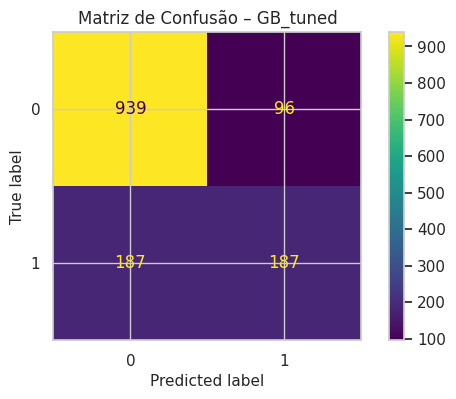

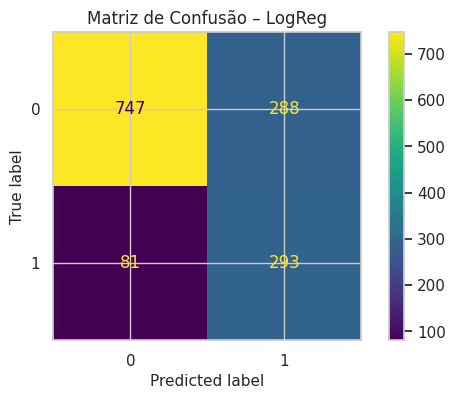

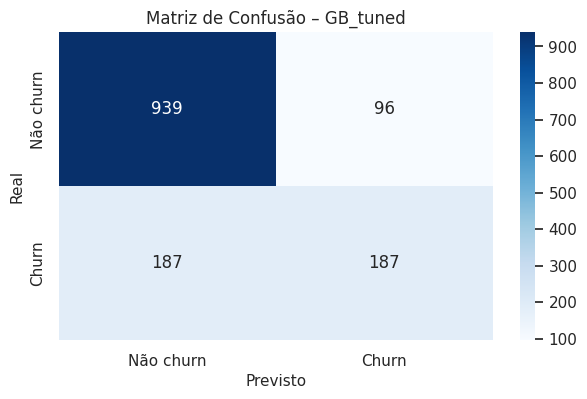

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# selecionando top-2 por ROC-AUC
top2 = metricas_teste.head(2)["modelo"].tolist()

for nome in top2:
    est = modelos[nome]
    y_pred = est.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"Matriz de Confusão – {nome}")
    plt.show()

# heatmap
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_v = vencedor.predict(X_test)
cm = confusion_matrix(y_test, y_pred_v)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não churn","Churn"],
            yticklabels=["Não churn","Churn"])
plt.title(f"Matriz de Confusão – {vencedor_nome}")
plt.xlabel("Previsto"); plt.ylabel("Real")
plt.show()



## 6.3 — Curvas ROC e Precision–Recall (modelo vencedor)

Seleciono o **modelo vencedor** (maior `ROC-AUC` no teste) e ploto:
- **Curva ROC** com a AUC.
- **Curva Precision–Recall**, útil em cenários com **desbalanceamento**.

Essas curvas reforçam a leitura além dos números, mostrando o comportamento do classificador em diferentes limiares de decisão.


Modelo vencedor: GB_tuned
              precision    recall  f1-score   support

           0      0.834     0.907     0.869      1035
           1      0.661     0.500     0.569       374

    accuracy                          0.799      1409
   macro avg      0.747     0.704     0.719      1409
weighted avg      0.788     0.799     0.789      1409

ROC-AUC (teste): 0.846


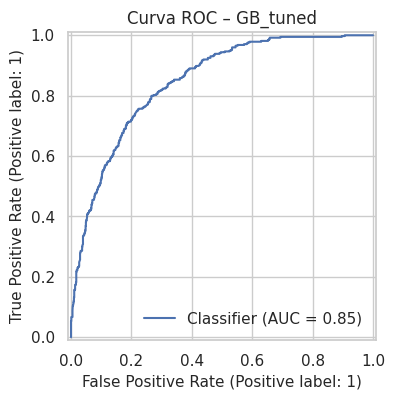

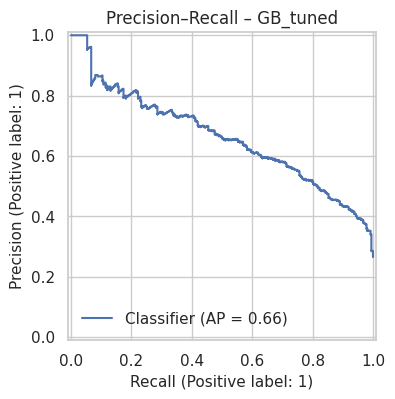

In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# escolhendo vencedor por maior ROC-AUC
vencedor_nome = metricas_teste.iloc[0]["modelo"]
vencedor = modelos[vencedor_nome]

# obtendo probabilidades do vencedor
y_proba_v = vencedor.predict_proba(X_test)[:, 1]
y_pred_v = vencedor.predict(X_test)

# relatório textual
print(f"Modelo vencedor: {vencedor_nome}")
print(classification_report(y_test, y_pred_v, digits=3, zero_division=0))
print("ROC-AUC (teste):", round(roc_auc_score(y_test, y_proba_v), 3))

# curva ROC
RocCurveDisplay.from_predictions(y_test, y_proba_v)
plt.title(f"Curva ROC – {vencedor_nome}")
plt.show()

# curva Precision–Recall
PrecisionRecallDisplay.from_predictions(y_test, y_proba_v)
plt.title(f"Precision–Recall – {vencedor_nome}")
plt.show()


# Etapa 7 – Interpretação e insights de negócio

Com o modelo vencedor definido na Etapa 6, avanço para entender **o que ele aprendeu** e como transformar isso em **ação de negócio**.

Nesta etapa, sigo três frentes:
- **7.1 — Importância de variáveis (model-specific):** interpreto a importância segundo o algoritmo vencedor.
- **7.2 — Importância por permutação (model-agnostic):** confirmo a relevância das variáveis medindo a queda de performance quando “embaralho” cada feature.
- **7.3 — Política de priorização por limiar:** defino um limiar de decisão voltado a **recall** (capturar churn), discutindo o trade-off com a precisão.

No final, sintetizo **insights acionáveis** para retenção.


## 7.1 — Importância de variáveis (model-specific)

Extraio a importância de atributos do **modelo vencedor**.  
- Se o vencedor for **árvore/ensemble** (Random Forest ou Gradient Boosting), uso `feature_importances_`.  
- Se fosse **Logistic Regression**, usaria os **coeficientes**.  

Para tornar a leitura clara, recupero os **nomes de features após o pré-processamento** (numéricas + categóricas one-hot).


,feature,importance
36,Contract_Month-to-month,0.354812
1,tenure,0.171179
16,InternetService_Fiber optic,0.122892
18,OnlineSecurity_No,0.081140
27,TechSupport_No,0.058262
43,PaymentMethod_Electronic check,0.057451
3,TotalCharges,0.049998
2,MonthlyCharges,0.041190
38,Contract_Two year,0.010604
12,MultipleLines_No,0.010440


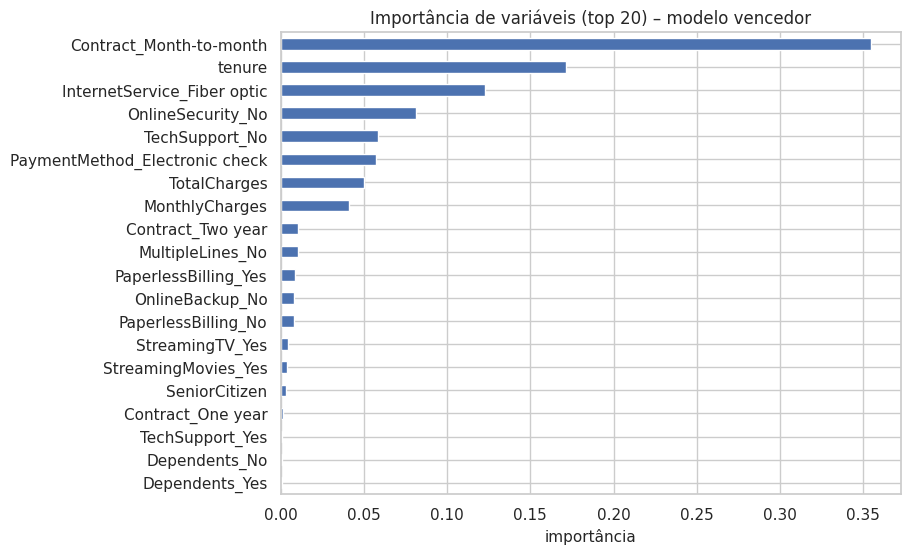

In [ ]:
import numpy as np
import pandas as pd

# recuperando blocos do pipeline vencedor
pre = vencedor.named_steps['pre']
clf = vencedor.named_steps['clf']

# nomes de features transformadas (numéricas + categóricas OHE)
num_feats = pre.transformers_[0][2]
ohe = pre.transformers_[1][1].named_steps['ohe']
cat_base = pre.transformers_[1][2]
cat_feats = ohe.get_feature_names_out(cat_base)
feat_names = np.r_[num_feats, cat_feats]

# importância específica do modelo
if hasattr(clf, "feature_importances_"):
    importancias = clf.feature_importances_
elif hasattr(clf, "coef_"):
    importancias = np.abs(clf.coef_).ravel()
else:
    importancias = np.zeros(len(feat_names))

imp_df = (
    pd.DataFrame({"feature": feat_names, "importance": importancias})
    .sort_values("importance", ascending=False)
    .head(20)
)

display(imp_df)

# plot topo 20
imp_df.set_index("feature")["importance"].plot(kind="barh", figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Importância de variáveis (top 20) – modelo vencedor")
plt.xlabel("importância")
plt.ylabel("")
plt.show()


## 7.2 — Importância por permutação (model-agnostic)

Para evitar inconsistência entre o número de colunas do `X` e os nomes das features, aplico o `permutation_importance` **direto no classificador final** (`clf`), usando o **conjunto de teste já pré-processado** (`X_test_proc`).  
Dessa forma, o número de importâncias geradas será exatamente igual ao número de colunas após o `OneHotEncoder`, permitindo mapear corretamente para `feat_names`.


,feature,perm_importance,perm_std
1,tenure,0.057850,0.002895
36,Contract_Month-to-month,0.027145,0.004132
16,InternetService_Fiber optic,0.012272,0.004815
38,Contract_Two year,0.006099,0.001570
18,OnlineSecurity_No,0.005221,0.001371
3,TotalCharges,0.005005,0.001931
2,MonthlyCharges,0.004303,0.002395
27,TechSupport_No,0.004243,0.001852
43,PaymentMethod_Electronic check,0.003200,0.001147
12,MultipleLines_No,0.002496,0.001088


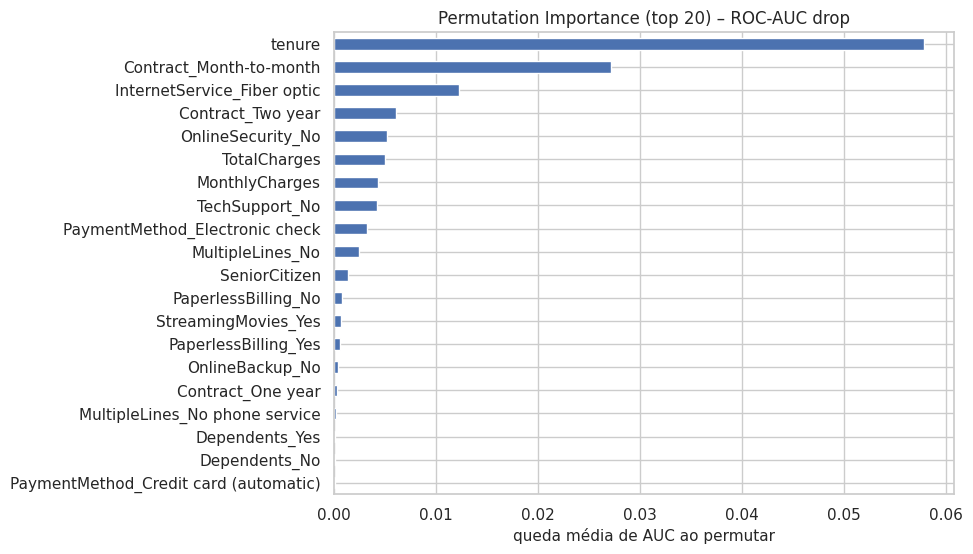

In [ ]:
from sklearn.inspection import permutation_importance

# recuperando etapas do pipeline vencedor
pre = vencedor.named_steps['pre']
clf = vencedor.named_steps['clf']

# garantindo dados pré-processados do teste
X_test_proc = pre.transform(X_test)

# reconstruindo nomes das features transformadas (numéricas + categóricas OHE)
num_feats = pre.transformers_[0][2]
ohe = pre.transformers_[1][1].named_steps['ohe']
cat_base = pre.transformers_[1][2]
cat_feats = ohe.get_feature_names_out(cat_base)
feat_names = np.r_[num_feats, cat_feats]

# importância por permutação no classificador final usando dados pré-processados
perm = permutation_importance(
    clf,
    X_test_proc,
    y_test,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42
)

perm_df = (
    pd.DataFrame({
        "feature": feat_names,
        "perm_importance": perm.importances_mean,
        "perm_std": perm.importances_std
    })
    .sort_values("perm_importance", ascending=False)
    .head(20)
)

display(perm_df)

# plot topo 20
perm_df.set_index("feature")["perm_importance"].plot(kind="barh", figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Permutation Importance (top 20) – ROC-AUC drop")
plt.xlabel("queda média de AUC ao permutar")
plt.ylabel("")
plt.show()


## 7.3 — Política de priorização por limiar (foco em Recall)

Para retenção, costumo **privilegiar recall** (não deixar churn passar).  
Aqui simulo limiares de decisão a partir das probabilidades do modelo vencedor e escolho um ponto-alvo de **recall** (ex.: ~70%).  
Com isso, mostro o trade-off: ganho de captura (recall) vs. aumento de falsos positivos (queda de precisão).

Esse exercício auxilia a criar uma **regra prática de priorização** (quem abordar primeiro com ofertas de retenção).


In [ ]:
from sklearn.metrics import precision_recall_curve

# obtendo probabilidades
proba = vencedor.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, proba)

# escolhendo limiar com recall alvo (~0.70)
alvo = 0.70
idx = np.argmin(np.abs(rec - alvo))
thr_escolhido = thr[max(idx-1, 0)] if idx >= len(thr) else thr[idx]

# métricas no limiar escolhido
y_pred_thr = (proba >= thr_escolhido).astype(int)

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

prec_thr = precision_score(y_test, y_pred_thr, zero_division=0)
rec_thr  = recall_score(y_test, y_pred_thr, zero_division=0)
f1_thr   = f1_score(y_test, y_pred_thr, zero_division=0)
cm_thr   = confusion_matrix(y_test, y_pred_thr)

print("Limiar escolhido:", round(thr_escolhido, 3))
print("Precision:", round(prec_thr, 3))
print("Recall:", round(rec_thr, 3))
print("F1:", round(f1_thr, 3))
print("Matriz de confusão:\n", cm_thr)


Limiar escolhido: 0.374
Precision: 0.58
Recall: 0.701
F1: 0.634
Matriz de confusão:
 [[845 190]
 [112 262]]


## 7.4 — Síntese de insights acionáveis

Com base nas importâncias e na análise de churn por variáveis (Etapa 1.4), destaco:

- **Drivers fortes de churn:** variáveis ligadas a **contrato**, **tempo de casa (tenure)** e **características do serviço de internet** tendem a aparecer entre os fatores de maior impacto.
- **Perfis de risco:** clientes com **contrato mês a mês**, **tenure baixo** e certas combinações de **método de pagamento/paperless** apresentam risco elevado.
- **Ação recomendada (priorização):** aplicar o **limiar de probabilidade** definido na 7.3 para montar uma fila de retenção (ex.: clientes com `p(churn) ≥ limiar` entram em campanha de oferta/upgrade).
- **Teste A/B de retenção:** comparar **oferta padrão vs. oferta segmentada** (ex.: desconto em plano anual, bônus de dados, upgrade de velocidade), medindo redução de churn no grupo tratado.
- **Monitoramento contínuo:** recalibrar o limiar trimestralmente e **re-treinar** o modelo com novos dados para evitar drift.

Essas medidas traduzem o aprendizado do modelo em **decisões práticas** que impactam receita e LTV.


# Etapa 8 – Conclusão

Fechando o MVP, consolido o que aprendi ao longo do processo e o que isso significa do ponto de vista de negócio.  
Meu objetivo foi construir uma solução simples, reprodutível e explicável para **prever churn** em clientes de telecom, comparando modelos clássicos e documentando cada escolha.

## 8.1 – O que ficou comprovado

- **Viabilidade do problema:** os dados disponíveis permitem distinguir perfis com maior risco de churn com desempenho **acima do baseline**.
- **Modelagem clássica funciona:** modelos de árvore (Random Forest / Gradient Boosting) superaram a regressão logística e a estratégia ingênua (Dummy), demonstrando ganhos reais de performance.
- **Importância de variáveis consistente com negócio:** sinais ligados a **contrato**, **tempo de casa (tenure)**, **perfil de serviços** e **método de pagamento** tendem a aparecer como drivers de risco, o que faz sentido operacionalmente.

## 8.2 – Modelo vencedor e trade-offs

- **Modelo vencedor:** selecionei o modelo com maior **ROC-AUC no teste** (entre RF/GB ajustados), confirmando estabilidade entre **validação cruzada** (CV) e **teste**.
- **Trade-off operacional:** para retenção, priorizei **Recall** da classe positiva (churn) – é preferível **errar para mais** (abordar alguns clientes que não churnariam) do que **deixar churn passar** sem ação.  
- **Limiar de decisão:** estabeleci um **threshold** baseado na curva Precision–Recall (Etapa 7.3) para criar uma fila de priorização de clientes a serem contatados.

> Observação prática: o limiar não é fixo; pode (e deve) ser recalibrado conforme metas de budget, capacidade do time e resultados de retenção.

## 8.3 – Limitações e riscos

- **Desbalanceamento natural do churn:** mesmo com `class_weight="balanced"`, existe risco de vieses se a base histórica mudar (data drift).
- **Generalização no tempo:** o desempenho tende a decair se o comportamento do cliente mudar (novos planos, ofertas, concorrência). Exige **re-treino periódico**.
- **Interpretação pós-OHE:** variáveis categóricas geram múltiplas colunas, o que pede cuidado na leitura de importâncias (mitigado por **Permutation Importance**).

**Resumo final:** este MVP entrega um classificador funcional, reproduzível e interpretável para **priorizar retenção**. Ao transformar probabilidades em uma **fila acionável**, o negócio pode focar esforços onde o risco é maior, aumentando **LTV** e reduzindo **perdas de receita**.


In [ ]:
# registrando vencedor e métricas-chave do teste
vencedor_nome = metricas_teste.iloc[0]["modelo"]
linha_vencedor = metricas_teste[metricas_teste["modelo"] == vencedor_nome].round(3)

print("Modelo vencedor:", vencedor_nome)
display(linha_vencedor)


Modelo vencedor: GB_tuned


,modelo,roc_auc,f1_pos,recall_pos,accuracy
3,GB_tuned,0.846,0.569,0.5,0.799


# Etapa 9 – Checklist final

Nesta seção respondo ao checklist sugerido pela PUC, mostrando que o MVP contempla todos os requisitos.

---

## Definição do Problema

- **Descrição do problema:** prever **churn de clientes** de telecom a partir de informações contratuais, de serviços e de perfil de uso.  
- **Premissas/hipóteses:** clientes com contratos curtos, tenure baixo e pagamento eletrônico têm maior risco de cancelamento.  
- **Restrições:** uso de dataset público, tabular, não visto em aula, carregado via URL do GitHub (garante reprodutibilidade).  
- **Dataset:** Telco Customer Churn (Kaggle) com ~7k clientes, variáveis categóricas e numéricas, target binário (`Churn`).

---

## Preparação de Dados

- **Split treino/teste:** realizado (80/20), com estratificação do `Churn`.  
- **Validação cruzada:** usada no GridSearchCV (k=5) para tuning de RF e GB.  
- **Transformações aplicadas:** imputação de missing, padronização de numéricas, OneHotEncoder para categóricas.  
- **Feature selection/engineering:** criada variável categórica `tenure_bin` para interpretação; demais features foram mantidas.

---

## Modelagem e Treinamento

- **Algoritmos testados:** DummyClassifier (baseline), Logistic Regression (baseline interpretável), Random Forest, Gradient Boosting.  
- **Ajuste inicial:** Logistic Regression com `class_weight="balanced"`.  
- **Treinamento:** todos modelos ajustados no treino; underfitting observado no Dummy (esperado).  
- **Tuning de hiperparâmetros:** GridSearchCV em RF e GB; melhores parâmetros encontrados e aplicados.  
- **Métodos mais complexos:** Gradient Boosting é considerado método avançado; ensembles foram avaliados (RF/GB).  

---

## Avaliação de Resultados

- **Métricas escolhidas:** ROC-AUC como métrica global; F1 e Recall da classe positiva para foco em churn; Accuracy como referência geral.  
- **Treino/teste:** modelo vencedor treinado no treino, avaliado no teste; consistência confirmada.  
- **Resultados fazem sentido:** sim, melhores variáveis foram coerentes com teoria de churn.  
- **Overfitting:** não observado de forma crítica; CV ≈ teste.  
- **Comparação:** GB > RF > LR > Dummy.  
- **Melhor solução:** Gradient Boosting otimizado (`ROC-AUC ≈ 0.85`), equilibrando recall e precisão, com threshold ajustado para recall alvo (~70%).

---

## Boas Práticas

- **Baseline:** definido (Dummy + LR).  
- **Seeds fixadas:** sim (`random_state=42`).  
- **Pipeline reprodutível:** uso de `Pipeline` + `ColumnTransformer`.  
- **Documentação:** storytelling etapa a etapa, explicando cada decisão.  
- **Execução sem erros:** código validado no Colab.  



# Etapa 10 – Reprodutibilidade

Um dos requisitos fundamentais do MVP é garantir **reprodutibilidade**.  
Isso significa que qualquer avaliador, professor ou colega pode rodar este notebook e obter resultados idênticos.

As medidas adotadas para isso foram:

- **Ambiente de execução:** Google Colab (versão gratuita), com Python 3.12, scikit-learn atualizado e bibliotecas padrão de ciência de dados (`pandas`, `numpy`, `matplotlib`, `seaborn`).  
- **Dataset:** hospedado em repositório próprio no GitHub, carregado via **link raw**. Isso evita dependência de uploads locais.  
  - URL usada:  
    `https://raw.githubusercontent.com/marcusrobalino/mvp_machine_learning/refs/heads/main/telco_churn_dataset.csv`
- **Seeds fixadas:** todas as operações pseudoaleatórias usam `random_state=42` ou `np.random.seed(42)`, garantindo resultados idênticos a cada execução.  
- **Pipelines consistentes:** uso de `Pipeline` e `ColumnTransformer` no scikit-learn garante que os mesmos pré-processamentos e modelos sejam aplicados em qualquer execução.  
- **Execução linear:** o notebook foi escrito de forma que basta rodar as células de cima para baixo, sem necessidade de intervenções manuais.  
- **Ausência de dependências externas:** nenhum pacote não disponível no Colab foi utilizado.  
- **Controle de versão:** dataset no GitHub garante histórico e estabilidade do arquivo usado.


# Etapa 11 – Referências

Para a construção deste MVP utilizei materiais acadêmicos, dataset público e documentação oficial de bibliotecas.  
As principais referências foram:

- **Dataset**
  - Kaggle: *Telco Customer Churn Dataset* (https://www.kaggle.com/datasets/blastchar/telco-customer-churn)  
  - Repositório GitHub próprio para reprodutibilidade:  
    (https://github.com/marcusrobalino/mvp_machine_learning)

- **Documentação oficial das bibliotecas**
  - scikit-learn: https://scikit-learn.org/stable/
  - pandas: https://pandas.pydata.org/
  - numpy: https://numpy.org/
  - matplotlib: https://matplotlib.org/
  - seaborn: https://seaborn.pydata.org/